# Estimación de Profundidad con Detección de Objetos; Deep Learning, CNN & Transformers

## Introducción

En este notebook se aborda el problema de la estimación monocular de profundidad a partir de imágenes utilizando el modelo Intel/dpt-large, un modelo de la librería transformers de HuggingFace para la tarea de depth-estimation. El objetivo principal es observar cómo este modelo es capaz de estimar la profundidad relativa en imágenes con objetos situados a distintas distancias y comparar visualmente los resultados. Además, se estudia cómo se pueden extraer conclusiones útiles a partir de estos mapas de profundidad.

Una vez obtenidos los resultados en imágenes estáticas, el análisis se extiende a secuencias animadas en formato GIF, por ser una alternativa ligera a los vídeos. Para enriquecer esta parte del proyecto, se incorpora el modelo maskrcnn_resnet50_fpn de torchvision, que permite detectar objetos en cada fotograma del GIF con máscaras. Con esto, no solo se pretende generar un mapa de profundidad por frame, sino también identificar regiones asociadas a objetos concretos y calcular la distancia estimada a la que se encuentran dichos objetos, extrayendo el valor medio de profundidad dentro de la máscara correspondiente.

El caso de uso elegido para los GIFs son sobre un par de escenarios de conducción por carretera, simulando un contexto aplicable, como es el caso de la conducción autónoma. En este entorno, conocer la distancia relativa de otros vehículos, peatones, señales o cualquier obstáculo es crucial para una toma de decisiones segura. La estimación de profundidad con visión monocular basada en CNN es la base de aplicaciones utilizada en campos como la robótica, realidad aumentada/virtual o navegación, al permitir conocer la estructura 3D de un entorno con una sola imagen.

Para resumir, el proyecto se apoya en herramientas como PyTorch y la librería transformers para visualizar de forma clara tanto estos mapas de profundidad como los resultados de detección de objetos, incluyendo anotaciones sobre cada frame con las distancias estimadas. La combinación de ambas tareas permite obtener una interpretación más rica de la escena visual, con potencial para aplicaciones reales de percepción en robótica móvil o vehículos autónomos.

## Estimación de Profundidad en Imágenes Estáticas

Cargamos y visualizamos las imágenes comparativas a estimar su profundidad.

In [1]:
from PIL import Image

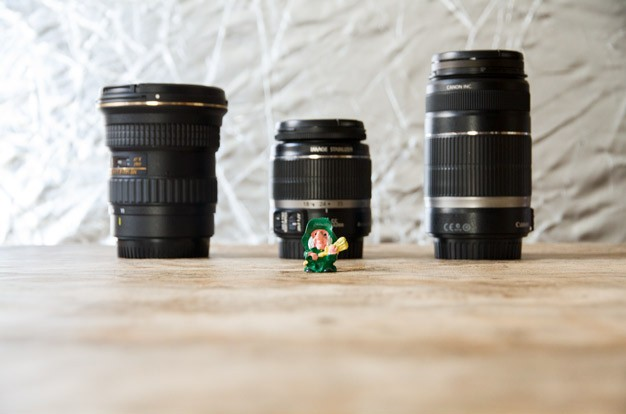

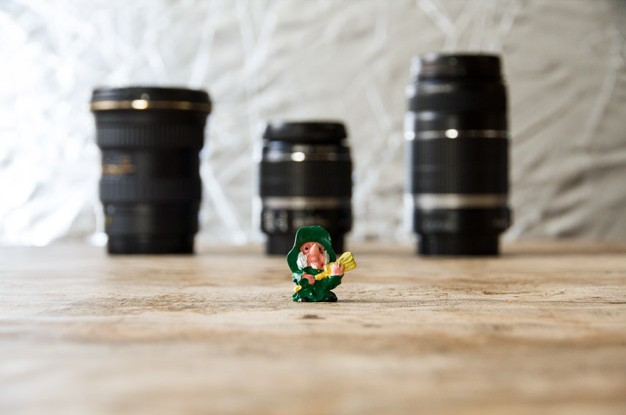

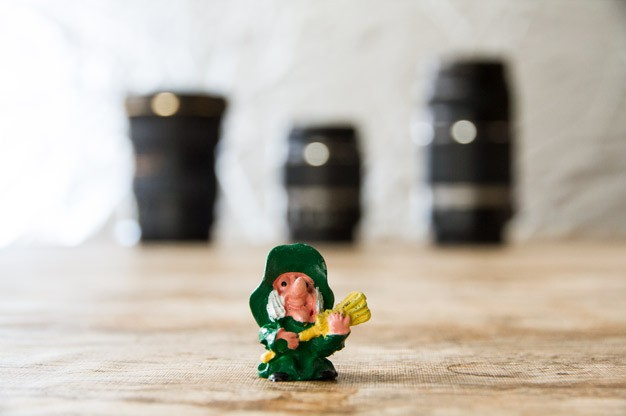

In [2]:
raw_image_path = '..\\data\\images'
images = ['depth_distances1.jpg', 'depth_distances2.jpg', 'depth_distances3.jpg']

for i in images:
    display(Image.open(f"{raw_image_path}\\{i}"))

Para estimar la profundidad de estas imágenes se usará el modelo transformers Depth Predicition Tranformer Large de Intel disponible en HuggingFace.

[Intel/dpt-large](https://huggingface.co/Intel/dpt-large)

El DPTImageProcessor es el preprocesador encargado de redimensionar la imagen al tamaño correcto, normalizar los pixeles, cambiar el formato a tensores y añadir la dimensión del batch. Mientras que el DPTForDepthEstimation es el propio modelo que toma la imagen como entrada y predice un mapa de profundidad con escala de grises que ofrece como salida.

In [3]:
from transformers.utils import logging
logging.set_verbosity_error()

import numpy as np
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch

In [4]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Tomemos una de las tres imagenes anteriores para dar como input a processor. Aquí es donde se transforma la imagen a tensores de PyTorch para que posteriormente model haga su trabajo como anteriormente se ha explicado.

In [5]:
image = Image.open(f"{raw_image_path}\\{images[1]}")

inputs = processor(images=image, return_tensors="pt")

Aplicamos el modelo a la imagen preprocesada y obtenemos el mapa de profundidad un tensor 2D donde cada número representa la profundidad relativa de cada píxel en la imagen, con torch.no_grad() para evitar construir el grafo para calcular los gradientes, puesto que no queremos hacer ningñun entrenamiento, solo predecir. En el contexto del modelo Intel/dpt-large cuanto mayor es este número, a mayor profundidad relativa está ese píxel. 

In [6]:
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

predicted_depth

tensor([[[ 1.9383,  1.9291,  1.9711,  ...,  3.3604,  3.3521,  3.1940],
         [ 1.9404,  1.8813,  1.9040,  ...,  3.3838,  3.3611,  3.3199],
         [ 1.9427,  1.9178,  1.9391,  ...,  3.4249,  3.4203,  3.3743],
         ...,
         [60.2462, 60.4631, 60.3000,  ..., 57.8382, 57.8221, 57.9692],
         [60.7762, 60.7780, 60.7037,  ..., 58.1149, 58.0655, 58.0962],
         [60.9290, 60.9457, 60.8879,  ..., 58.3824, 58.5018, 58.4178]]])

Con .shape al modelo predicted_depth obtenemos la dimensionalidad del tensor del tipo [batch, height, widht], para posteriormente interpolar con la función torch.nn.functional.interpolate y obtener la predicción de predicted_depth sobre la imagen inicial.

In [7]:
predicted_depth.shape

torch.Size([1, 384, 384])

Aplicamos la interpolación: como torch.nn.functional.interpolate necesita que los datos estén en el formato de 4D, con .unsqueeze(1) añadimos la dimensión de channel, image.size[::-1] escala el mapa de profundidad al tamaño de la imagen original, mode y align_corners refiere a la interpolación usada para redimensionar suavemente el mapa.

In [8]:
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

Por último, convertimos la predicción a una imagen en escala de grises, aplicando a prediction .squeeze() para quitar las dimensiones de tamaño 1 del tensor que solo se implementaron para poder realziar la interpolación, y nos quedamos con las dimensiones [height, widht] y convertimos dicho tensor a un array de numpy. Posteriormente desescalamos el output que normalizamos anteriormente y visulizamos la imagen predicha.

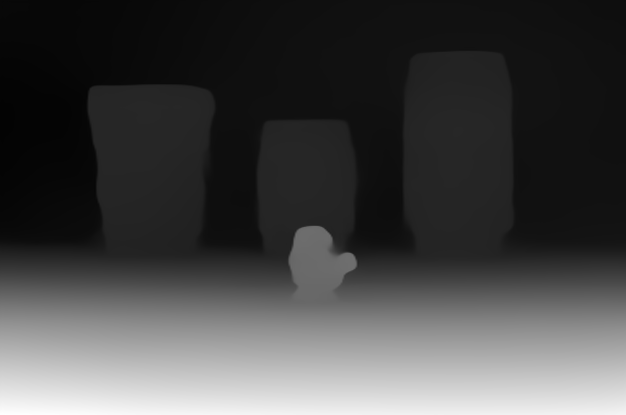

In [9]:
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
Image.fromarray(formatted)

Con esta estructura desglosada y explicada paso a paso, realicemos la comparativa de la profundidad de las tres imagenes aplicando un bucle al pipeline del modelo ofrecido en HuggingFace, que es simplemente, lo anteriormente explicado estructurado en un pipeline. 

In [10]:
from transformers import pipeline

pipe = pipeline(task="depth-estimation", model="Intel/dpt-large")

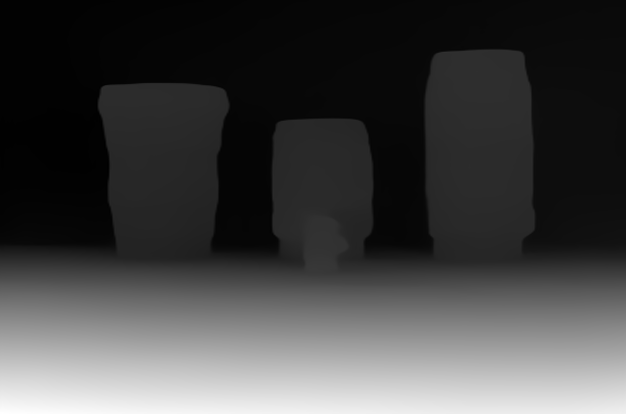

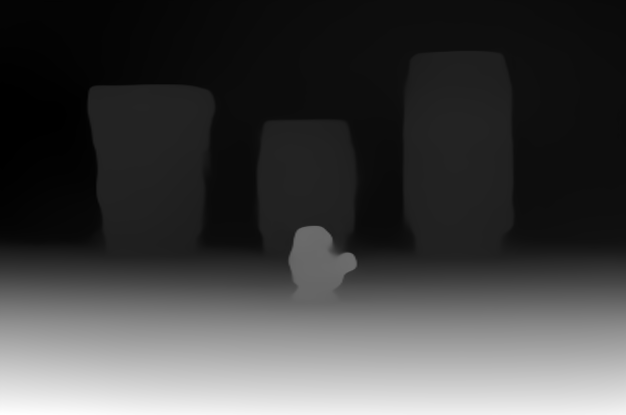

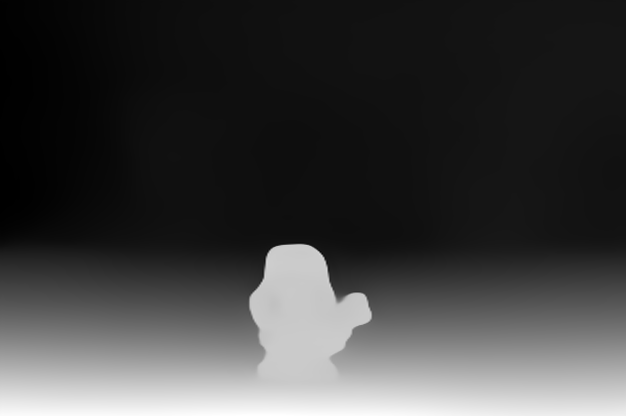

In [11]:
for i in images:
    result = pipe(Image.open(f"{raw_image_path}\\{i}"))
    display(result["depth"])

Se observa como el color de la miniatura cambia en la escala de grises de negro a blanco según su cercanía, además, mencionar como en la tercera imagen no se distingue la escala de grises de los tres objetivos del fondo por estar desenfocados.

## Detección de Objetos + Estimación de Profundidad en Videos

Para este apartado, se aplicará la estimación de profundidad a imágenes en formato .gif, esto es aplicar lo mismo ya visto pero frame a frame. Además, se sumará a esto la detección de objetos con su respectivo parámetro de profundidad a establecer para concocer que tan lejos se encuentra cada objeto del video en todo momento.

In [12]:
from IPython.display import Image as IPyImage, display

In [13]:
raw_gif_path = '..\\data\\gifs'
gifs = ['driving_city_asia.gif', 'driving_highway.gif']

#for i in gifs:
    #display(IPyImage(filename=f"{raw_gif_path}\\{i}"))

Para la detección de objetos, se hará uso del modelo maskrcnn_resnet50_fpn de la librería PyTorch en modo evaluación para desactivar capas como Dropout y BatchNorm referentes a entrenamiento, esto se hace porque se va a utilizar un modelo preentrenado para inferencia, es decir, para predecir directamente y no entrenar.

[maskrcnn_resnet50_fpn](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html#torchvision.models.detection.maskrcnn_resnet50_fpn)

In [14]:
import torchvision.models.detection as detection

In [15]:
mask_rcnn = detection.maskrcnn_resnet50_fpn(pretrained=True)
mask_rcnn.eval();

c:\Users\jeje9\Projects\Depth Distant Objects CNN\env_depth_obj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jeje9\Projects\Depth Distant Objects CNN\env_depth_obj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
from PIL import ImageSequence, ImageDraw, ImageFont
from torchvision import transforms

En primer lugar tenemos una función que detecta los objetos de la imagen (frame) para un umbral superior a un score establecido de 0.7, si es así, se crea la mascara en función de aquellos pixeles dados como pertenecientes a la máscara del objeto a delimitar superior a 0.5, y luego se crea la profundidad media de esa máscara del objeto.

La siguiente parte de la función refiere a la problemática de dos objetos que se solapan uno detrás de otro, dadas dos máscaras superpuestas, la del fondo puede coger valores de estimación de la profundidad del objeto de delante, por ello, se configura solo tomar en cuenta el objeto de delante. Creamos la variable reemplazado = False, y se realiza un nuevo bucle que recorre los objetos detectados para ver si hay píxeles coincidentes en las máscaras de los dos objetos, si es así, se queda con el objeto que se sencuentré más cercano y cambia reemplazado = True, en cambio, si no hay píxeles conicidentes con otro objeto, lo añade directamente a objetos_filtrados.

In [17]:
def object_filter(detections, depth_array, threshold=0.7):
    objetos_filtrados = []

    for i in range(len(detections['boxes'])):
        score = detections['scores'][i].item()
        if score >= threshold:
            mask1 = detections['masks'][i, 0].cpu().numpy() > 0.5
            if np.any(mask1):
                depth1 = np.mean(depth_array[mask1])

                reemplazado = False
                for j, (mask2, depth2) in enumerate(objetos_filtrados):
                    if np.any(np.logical_and(mask1, mask2)):
                        if depth1 > depth2:
                            objetos_filtrados[j] = (mask1, depth1)
                        reemplazado = True
                        break

                if not reemplazado:
                    objetos_filtrados.append((mask1, depth1))

    return objetos_filtrados

La siguiente función sencillamente dibuja el delimitador de la máscara de cada objeto e indíca la profundidad media estimada.

In [18]:
def object_draw(draw, object_filter):
    for mask, depth in object_filter:
        y, x = np.where(mask)
        if len(x) > 0 and len(y) > 0:
            
            x1, y1, x2, y2 = int(x.min()), int(y.min()), int(x.max()), int(y.max())
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1 - 10), f"Object Depth: {depth:.1f}", fill="red", font=ImageFont.load_default())

La función frame_processor procesa cada frame, para calcular las estimaciones de profundidad de cada píxel según el pipeline de Intel\dpt-large como anteriormente ya se ha expuesto, y para cada objeto detectado con maskrcnn_resnet50_fpn, hace llamadas a las otras dos funciones ya explicadas.

In [19]:
def frame_processor(frame, pipe, mask_rcnn):
    frame = frame.convert("RGB")

    result = pipe(frame)
    depth_img = result["depth"].convert("RGB")
    depth_array = result["predicted_depth"].squeeze().cpu().numpy()

    input_tensor = transforms.ToTensor()(frame)
    with torch.no_grad():
        detections = mask_rcnn([input_tensor])[0]

    draw = ImageDraw.Draw(depth_img)
    objetos = object_filter(detections, depth_array)
    object_draw(draw, objetos)

    return depth_img

Para finalizar, creemos una clase que agrupe estas funciones para tener estructura organizada.

In [20]:
class GIFDepthProcessor:
    def __init__(self, pipe, mask_rcnn, score_threshold=0.7):
        self.pipe = pipe
        self.mask_rcnn = mask_rcnn
        self.score_threshold = score_threshold

    def object_filter(self, detections, depth_array):
        return object_filter(detections, depth_array, self.score_threshold)

    def object_draw(self, draw, objetos_filtrados):
        return object_draw(draw, objetos_filtrados)

    def frame_processor(self, frame):
        return frame_processor(frame, self.pipe, self.mask_rcnn)

Instanciamos la clase creada y la aplicamos al gif.

In [21]:
depth_mask = GIFDepthProcessor(pipe, mask_rcnn)

In [22]:
gif_path = f"{raw_gif_path}\\{gifs[1]}"
original_gif = Image.open(gif_path)
duration = original_gif.info.get('duration', 100)

frames_lista = []

for frame in ImageSequence.Iterator(original_gif):
    frame = frame.convert("RGB")
    depth_img = depth_mask.frame_processor(frame)
    frames_lista.append(depth_img)

In [23]:
output_path = "gifHighway_depth_mask.gif"

frames_lista[0].save(
    output_path,
    save_all=True,
    append_images=frames_lista[1:],
    duration=duration,
    loop=0)

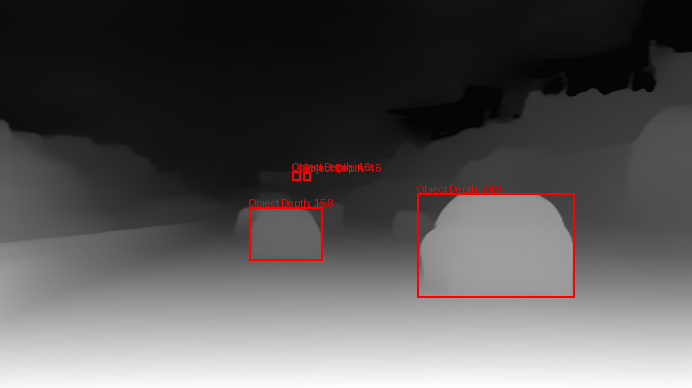

In [ ]:
display(IPyImage(filename=output_path))

Cerrando el desarrollo de este notebook, concluir que se ha diseñado un pipeline para procesar GIFs frame a frame, combinando modelos CNN para estimar mapas de profundidad basado en transformers de HuggingFace, junto con segmentación de objetos mediante Mask R-CNN de PyTorch. La lógica implementada permite estimar la profundidad de cada píxel, detectar objetos mediante segmentación de máscaras, filtrar objetos solapados priorizando aquellos más cercanos a la cámara, y finalmente dibujar sobre cada frame información relevante como los bounding boxes y la profundidad media de cada objeto visible. Todo el flujo se estructuró en funciones y clases para favorecer la modularidad y claridad del código.

## Autor: Alfonso Guisado González